Mounted at /content/gdrive
Dataset loaded
175 224 (224, 224, 3) 75 175 75


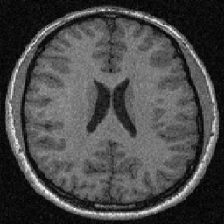

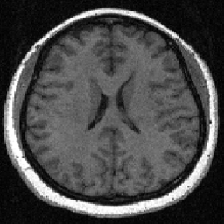

In [ ]:
import numpy as np
import cv2
import os
import re
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Load dataset and preprocess
healthy_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset_175/train/healthy'
schizophrenia_path_train = '/content/gdrive/My Drive/Colab Notebooks/dataset_175/train/schizophrenia'
healthy_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset_175/test/healthy'
schizophrenia_path_test = '/content/gdrive/My Drive/Colab Notebooks/dataset_175/test/schizophrenia'

def load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test):
    images_train = []
    images_test = []
    labels_train = []
    labels_test = []
    for img in os.listdir(healthy_path_train):
        img_path = os.path.join(healthy_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_train.append(image)
        labels_train.append(0)
    for img in os.listdir(schizophrenia_path_train):
        img_path = os.path.join(schizophrenia_path_train, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_train.append(image)
        labels_train.append(1)
    for img in os.listdir(healthy_path_test):
        img_path = os.path.join(healthy_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_test.append(image)
        labels_test.append(0)
    for img in os.listdir(schizophrenia_path_test):
        img_path = os.path.join(schizophrenia_path_test, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images_test.append(image)
        labels_test.append(1)
    return np.array(images_train), np.array(images_test), np.array(labels_train), np.array(labels_test)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = load_dataset(healthy_path_train, schizophrenia_path_train, healthy_path_test, schizophrenia_path_test)
print("Dataset loaded")

#print(X_train_dl, X_test_dl, y_train_dl, y_test_dl)
print(len(X_train_dl),len(X_train_dl[0]), X_train_dl[0].shape, len(X_test_dl), len(y_train_dl), len(y_test_dl))

from google.colab.patches import cv2_imshow
cv2_imshow(X_train_dl[5])
cv2_imshow(X_test_dl[5])

In [ ]:
import os
import time
import numpy as np
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


X_train_dl_split, X_test_dl_split, y_train_dl_split, y_test_dl_split  = X_train_dl, X_test_dl, to_categorical(y_train_dl, num_classes=2), to_categorical(y_test_dl, num_classes=2)
print(len(X_train_dl_split),len(X_train_dl_split[0]), X_train_dl_split[0].shape, len(X_test_dl_split), len(y_train_dl_split),  len(y_test_dl_split))

# Build and compile the model
base_model = tensorflow.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()
base_model.trainable = False

# Freeze all layers except some convolutional layers
for layer in base_model.layers[-50:]:
    layer.trainable = True
for layer in base_model.layers:
    print("{0}:\t{1}".format(layer.trainable, layer.name))

model = Sequential([
    layers.Rescaling(1./224),
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(2048, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation = 'relu'),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


175 224 (224, 224, 3) 75 175 75
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_940 (Conv2D)         (None, 111, 111, 32)         864       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_940 (B  (None, 111, 111, 32)         96        ['conv2d_940[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_940 (Activation  (None, 111, 111, 32)      

In [ ]:
history = model.fit(
    x = X_train_dl_split,
    y = y_train_dl_split,
    epochs=50,
    validation_split= 0.2
)


Epoch 1/50
6/6 [==============================] - 1s 117ms/step - loss: 0.7107 - accuracy: 0.6205 - val_loss: 1.0907 - val_accuracy: 0.0189
Epoch 2/50
6/6 [==============================] - 1s 111ms/step - loss: 0.6646 - accuracy: 0.6265 - val_loss: 0.7883 - val_accuracy: 0.3396
Epoch 3/50
6/6 [==============================] - 1s 116ms/step - loss: 0.6704 - accuracy: 0.6024 - val_loss: 0.6297 - val_accuracy: 0.6604
Epoch 4/50
6/6 [==============================] - 1s 111ms/step - loss: 0.6300 - accuracy: 0.6867 - val_loss: 0.6067 - val_accuracy: 0.7170
Epoch 5/50
6/6 [==============================] - 1s 111ms/step - loss: 0.6244 - accuracy: 0.6446 - val_loss: 0.6152 - val_accuracy: 0.6981
Epoch 6/50
6/6 [==============================] - 1s 114ms/step - loss: 0.6134 - accuracy: 0.6988 - val_loss: 0.6222 - val_accuracy: 0.6792
Epoch 7/50
6/6 [==============================] - 1s 119ms/step - loss: 0.6197 - accuracy: 0.6867 - val_loss: 0.6711 - val_accuracy: 0.6226
Epoch 8/50
6/6 [====

In [ ]:
# Evaluate the model
scores = model.evaluate(X_test_dl_split, y_test_dl_split, verbose=1)
y_pred_dl = model.predict(X_test_dl_split)

3/3 [==============================] - 0s 65ms/step


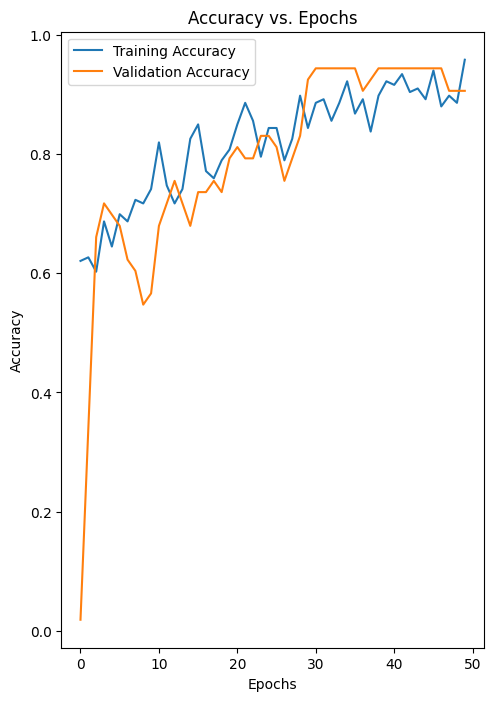

In [ ]:
y_pred_classes = np.argmax(y_pred_dl, axis=1)
y_true_classes = np.argmax(y_test_dl_split, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
specificity = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
recall = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])

# Plot training history
plt.figure(figsize=(12, 8))
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')  # Corrected ylabel to 'Accuracy'
plt.title('Accuracy vs. Epochs')
plt.legend()


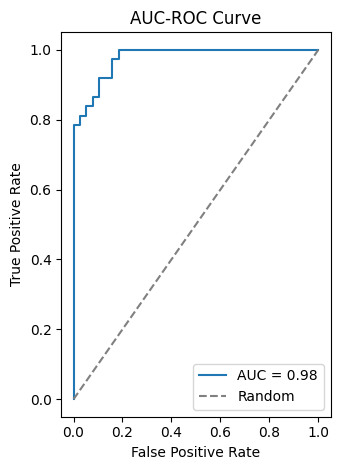

Test loss: 0.22332361340522766
Test accuracy: 0.8933333158493042
Sensitivity(recall): 0.8918918918918919
Specificity: 0.9210526315789473
Precision: 0.9166666666666666
F1 Score: 0.9041095890410958
AUC-ROC Score: 0.9765291607396871
[[35  3]
 [ 4 33]]
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_10 (Flatten)        (None, 51200)             0         
                                                                 
 dense_37 (Dense)            (None, 1024)              52429824  
                                                                 
 dropout_17 (Dropout)        (None, 1024)              0         
  

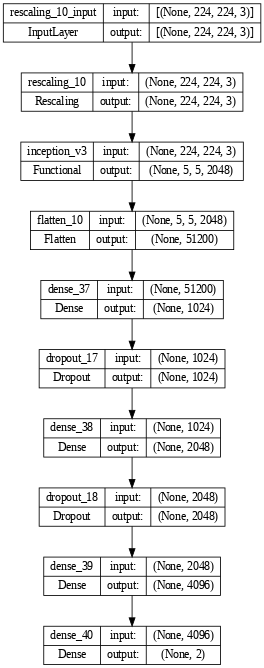

In [ ]:
# Plot AUC-ROC
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_true_classes, y_pred_dl[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print evaluation results
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Sensitivity(recall):', recall)
print('Specificity:', specificity)
print('Precision:', precision_score(y_true_classes, y_pred_classes))
print('F1 Score:', f1_score(y_true_classes, y_pred_classes))
print('AUC-ROC Score:', roc_auc_score(y_true_classes, y_pred_dl[:, 1]))
print(conf_matrix)
model.summary()

from tensorflow.keras.utils import plot_model
# Explore model visually
plot_model(
    model, dpi=60,
    show_shapes=True
)